In [10]:
from importlib import reload
import os
from time import time

import numpy as np
import scipy as sc
import pandas as pd
from statsmodels.stats.weightstats import _zstat_generic

import torch
print('Is CUDA available?')
print(torch.cuda.is_available())

import pprint
import editdistance

import utils
import tdre
import shifts
import viennarna_shifts as vshifts
import calibrate as cal

import flexs
import flexs.utils.sequence_utils as s_utils

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

Is CUDA available?
True


<IPython.core.display.Javascript object>

In [12]:
%%notify
reload(vshifts)
reload(tdre)
reload(cal)

# data 
landscape_name = 'L50_RNA1'
seed_idx = 4
avg_n_mut = 4
n = 5000
N = 20000
thresholds = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
explorer_kwarg_name2vals = {'threshold': thresholds}
save_fname_dir = '120423'
trial_idx = np.arange(20)
n_trial = trial_idx.size
taus = np.arange(0.34, 0.45, 0.02)
alpha = 0.1
lhat = 1

# TDRE
n_hidden = 256
n_waymarks_for_last_hp = 0
config = {
    'waymark_type': 'mixed_dimensions',  # dummy value
    'val_frac': 0.1,
    'n_steps': 2000,
    'lr': 1e-3,
    'use_weighted_loss': True
}
model = tdre.TelescopingLogDensityRatioEstimator(
    None,
    50 * 4,
    shared=False,
    multiclass=True,
    n_ratio=len(thresholds),
    n_waymarks_for_last_hp=n_waymarks_for_last_hp,
    device=torch.device('cuda'),
    dtype=torch.float
)

impmean_Txtx2 = np.zeros([n_trial, taus.size, 2])
impsz_Txt = np.zeros([n_trial, taus.size])
impfwer_t = np.zeros([taus.size])

ppmean_Txtx2 = np.zeros([n_trial, taus.size, 2])
ppsz_Txt = np.zeros([n_trial, taus.size])
ppfwer_t = np.zeros([taus.size])

format_str = ''.join(['{}'] + len(thresholds) * ['{:.3f} '])
pval_format_str = ''.join(len(thresholds) * ['{:.3f} '])

t0 = time()
for T_idx, T in enumerate(trial_idx):

    # X_m1xnxd, y_m1xn, pred_mxn, Xcal_nxd, ycal_n, predcal_n = vshifts.load_rna_data(
    X_mxnxd, y_mxn, pred_mxn, Xtrcal_nxd, Xcal_nxd, ycal_n, predcal_n = vshifts.load_rna_data(
        landscape_name,
        seed_idx,
        n,
        N,
        explorer_kwarg_name2vals,
        save_fname_dir,
        avg_n_mut,
        T
    )
    
    train_dfs = model.fit(config, X_m1xnxd=X_mxnxd, Xm_nxp=Xtrcal_nxd)
    truemean_m = np.mean(y_mxn, axis=1)
    
    # imputation point estimates
    imputed_m = np.mean(pred_mxn, axis=1)
    
    # PP point estimates
    pp_m, dr_nxm = model.forecast_meany_per_bridge(
        Xcal_nxd, ycal_n, self_normalized=True, predm_n=predcal_n, pred0_mxn=pred_mxn
    )
    
    print('Train mean: {:.3f}'.format(np.mean(ycal_n)))
    print(format_str.format('True means   :', *truemean_m))
    print(format_str.format('Imputed means:', *imputed_m))
    print(format_str.format('PP means     :', *pp_m))
    
    print('Imputation:')
    
    # imputation p-values
    impp_txm = np.array([
        [_zstat_generic(imp_est, 0, np.std(pred0_n) / np.sqrt(pred0_n.size), alternative='larger', diff=tau)[1]
         for imp_est, pred0_n in zip(imputed_m, pred_mxn)]
        for tau in taus
    ])
    impidx_t = [np.where(impp_m < alpha / len(thresholds))[0] for impp_m in impp_txm]
    for t, impidx in enumerate(impidx_t):
        # print('p-values for tau = {:.2f}'.format(taus[t]))
        # print(pval_format_str.format(*impp_txm[t]))
        
        if impidx.size:
            # 1) worst-case selected hyperparameter value and
            # 2) true quantity of most aggressive selected hyperparameter value
            impmean_Txtx2[T_idx, t] = np.min(truemean_m[impidx]), truemean_m[np.min(impidx)]  
            impsz_Txt[T_idx, t] = impidx.size
            if np.sum(truemean_m[impidx] >= taus[t]) < impidx.size:
                impfwer_t[t] += 1
            print('  tau = {:.2f}: {:.3f} {:.3f}. {} {:.3f}'.format(
                taus[t], impmean_Txtx2[T_idx, t, 0], impmean_Txtx2[T_idx, t, 1], impidx.size, impfwer_t[t] / (T_idx + 1)
            ))
        else:
            print('  No hyperparameters selected for tau = {:.2f}'.format(taus[t]))
    
    print('PP:')
    
    # PP p-values
    ppp_txm = np.array([
        [cal.ppi_mean_pval(ycal_n, predcal_n, pred0_n, lhat=lhat, null=tau, alternative='larger', w=dr_n)
         for pred0_n, dr_n in zip(pred_mxn, dr_nxm.T)]
        for tau in taus
    ])
    ppidx_t = [np.where(ppp_m < alpha / len(thresholds))[0] for ppp_m in ppp_txm]
    for t, ppidx in enumerate(ppidx_t):
        # print('p-values for tau = {:.2f}'.format(taus[t]))
        # print(pval_format_str.format(*ppp_txm[t]))
        
        if ppidx.size:
            ppmean_Txtx2[T_idx, t] = np.min(truemean_m[ppidx]), truemean_m[np.min(ppidx)]  
            ppsz_Txt[T_idx, t] = ppidx.size
            if np.sum(truemean_m[ppidx] >= taus[t]) < ppidx.size:
                ppfwer_t[t] += 1
            print('  tau = {:.2f}. {:.3f} {:.3f}. {} {:.3f}'.format(
                taus[t], ppmean_Txtx2[T_idx, t, 0], ppmean_Txtx2[T_idx, t, 1], ppidx.size, ppfwer_t[t] / (T_idx + 1)))
        else:
            print('  No hyperparameters selected for tau = {:.2f}'.format(taus[t]))
    print('Done with trial {} ({} s)\n'.format(T, int(time() - t0)))
    
impfwer_t /= n_trial
ppfwer_t /= n_trial

for t, tau in enumerate(taus):
    print('Tau = {:.2f}'.format(tau))
    
    impnonempty_trial_idx = np.where(impsz_Txt[:, t])[0]
    print('  Imp: min true value {:.3f}, true value of min {:.3f}, FWER {:.2f}, # selected {:.2f}, discovery rate {:.2f}'.format(
        np.median(impmean_Txtx2[impnonempty_trial_idx, t, 0]),
        np.median(impmean_Txtx2[impnonempty_trial_idx, t, 1]),
        impfwer_t[t],
        np.median(impsz_Txt[:, t]),
        impnonempty_trial_idx.size / n_trial,
    )
    )

    ppnonempty_trial_idx = np.where(ppsz_Txt[:, t])[0]
    print('   PP: min true value {:.3f}, true value of min {:.3f}, FWER {:.2f}, # selected {:.2f}, discovery rate {:.2f}'.format(
        np.median(ppmean_Txtx2[ppnonempty_trial_idx, t, 0]),
        np.median(ppmean_Txtx2[ppnonempty_trial_idx, t, 1]),
        ppfwer_t[t],
        np.median(ppsz_Txt[:, t]),
        ppnonempty_trial_idx.size / n_trial,
    )
    )
    

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ... where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/120423/L50_RNA1/trial0/seed4-n5000-nmut4-threshold0.01.npz
Loading from /data/wongfanc/dre-data/data/120423/L50_RNA1/trial0/seed4-n5000-nmut4-threshold0.05.npz
Loading from /data/wongfanc/dre-data/data/120423/L50_RNA1/trial0/seed4-n5000-nmut4-threshold0.1.npz
Loading from /data/wongfanc/dre-data/data/120423/L50_RNA1/trial0/seed4-n5000-nmut4-threshold0.2.npz
Loading from /data/wongfanc/dre-data/data/120423/L50_RNA1/trial0/seed4-n5000-nmut4-threshold0.3.npz
Loading from /data/wongfanc/dre-data/data/120423/L50_RNA1/trial0/seed4-n5000-nmut4-threshold0.4.npz
Loading from /data/wongfanc/dre-data/data/120423/L50_RNA1/trial0/seed4-n5000-nmut4-threshold0.5.npz
X_m1xnxd is shape (7, 20000, 200), Xm_nxp is shape (5000, 200). 7 waymarks provided


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 136.61it/s]


Train mean: 0.287
True means   :0.410 0.386 0.380 0.365 0.349 0.344 0.340 
Imputed means:0.438 0.429 0.427 0.413 0.402 0.399 0.396 
PP means     :0.394 0.394 0.389 0.373 0.367 0.364 0.365 
Imputation:
  tau = 0.34: 0.340 0.410. 7 1.000
  tau = 0.36: 0.340 0.410. 7 1.000
  tau = 0.38: 0.340 0.410. 7 1.000
  tau = 0.40: 0.349 0.410. 5 1.000
  tau = 0.42: 0.380 0.410. 3 1.000
  No hyperparameters selected for tau = 0.44
PP:
  No hyperparameters selected for tau = 0.34
  No hyperparameters selected for tau = 0.36
  No hyperparameters selected for tau = 0.38
  No hyperparameters selected for tau = 0.40
  No hyperparameters selected for tau = 0.42
  No hyperparameters selected for tau = 0.44
Done with trial 0 (17 s)

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ... where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/120423/L50_RNA1/trial1/seed4-n5000-nmut4-threshold0.01.npz
Load

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 136.32it/s]


Train mean: 0.284
True means   :0.380 0.373 0.378 0.363 0.351 0.346 0.342 
Imputed means:0.413 0.413 0.418 0.406 0.395 0.389 0.388 
PP means     :0.377 0.380 0.385 0.371 0.359 0.355 0.353 
Imputation:
  tau = 0.34: 0.342 0.380. 7 0.500
  tau = 0.36: 0.342 0.380. 7 1.000
  tau = 0.38: 0.342 0.380. 7 1.000
  tau = 0.40: 0.363 0.380. 4 1.000
  No hyperparameters selected for tau = 0.42
  No hyperparameters selected for tau = 0.44
PP:
  No hyperparameters selected for tau = 0.34
  No hyperparameters selected for tau = 0.36
  No hyperparameters selected for tau = 0.38
  No hyperparameters selected for tau = 0.40
  No hyperparameters selected for tau = 0.42
  No hyperparameters selected for tau = 0.44
Done with trial 1 (35 s)

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ... where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/120423/L50_RNA1/trial2/seed4-n5000-nmut4-threshold0.0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 135.24it/s]


Train mean: 0.285
True means   :0.398 0.389 0.382 0.369 0.357 0.350 0.349 
Imputed means:0.430 0.414 0.404 0.395 0.384 0.378 0.378 
PP means     :0.446 0.430 0.411 0.402 0.402 0.394 0.390 
Imputation:
  tau = 0.34: 0.349 0.398. 7 0.333
  tau = 0.36: 0.349 0.398. 7 1.000
  tau = 0.38: 0.357 0.398. 5 1.000
  tau = 0.40: 0.382 0.398. 3 1.000
  tau = 0.42: 0.398 0.398. 1 0.667
  No hyperparameters selected for tau = 0.44
PP:
  tau = 0.34. 0.349 0.398. 7 0.000
  tau = 0.36. 0.349 0.398. 6 0.333
  tau = 0.38. 0.382 0.398. 3 0.000
  tau = 0.40. 0.398 0.398. 1 0.333
  No hyperparameters selected for tau = 0.42
  No hyperparameters selected for tau = 0.44
Done with trial 2 (53 s)

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ... where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/120423/L50_RNA1/trial3/seed4-n5000-nmut4-threshold0.01.npz
Loading from /data/wongfanc/dre-data/data/12

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 136.26it/s]


Train mean: 0.284
True means   :0.410 0.409 0.394 0.369 0.354 0.347 0.344 
Imputed means:0.432 0.433 0.421 0.405 0.395 0.389 0.386 
PP means     :0.441 0.441 0.430 0.413 0.451 0.445 0.441 
Imputation:
  tau = 0.34: 0.344 0.410. 7 0.250
  tau = 0.36: 0.344 0.410. 7 1.000
  tau = 0.38: 0.344 0.410. 7 1.000
  tau = 0.40: 0.369 0.410. 4 1.000
  tau = 0.42: 0.394 0.410. 3 0.750
  No hyperparameters selected for tau = 0.44
PP:
  tau = 0.34. 0.369 0.410. 4 0.000
  tau = 0.36. 0.369 0.410. 4 0.250
  tau = 0.38. 0.369 0.410. 4 0.250
  tau = 0.40. 0.394 0.410. 3 0.500
  tau = 0.42. 0.409 0.410. 2 0.250
  No hyperparameters selected for tau = 0.44
Done with trial 3 (71 s)

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ... where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/120423/L50_RNA1/trial4/seed4-n5000-nmut4-threshold0.01.npz
Loading from /data/wongfanc/dre-data/data/120423/L50_R

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 135.98it/s]


Train mean: 0.285
True means   :0.393 0.394 0.382 0.367 0.357 0.349 0.346 
Imputed means:0.415 0.413 0.404 0.392 0.382 0.375 0.372 
PP means     :0.393 0.390 0.385 0.384 0.382 0.374 0.371 
Imputation:
  tau = 0.34: 0.346 0.393. 7 0.200
  tau = 0.36: 0.346 0.393. 7 1.000
  tau = 0.38: 0.357 0.393. 5 1.000
  tau = 0.40: 0.382 0.393. 3 1.000
  No hyperparameters selected for tau = 0.42
  No hyperparameters selected for tau = 0.44
PP:
  tau = 0.34. 0.346 0.393. 7 0.000
  tau = 0.36. 0.346 0.367. 4 0.400
  No hyperparameters selected for tau = 0.38
  No hyperparameters selected for tau = 0.40
  No hyperparameters selected for tau = 0.42
  No hyperparameters selected for tau = 0.44
Done with trial 4 (89 s)

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ... where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/120423/L50_RNA1/trial5/seed4-n5000-nmut4-threshold0.01.npz
Loading from /

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 137.94it/s]


Train mean: 0.286
True means   :0.390 0.384 0.386 0.367 0.354 0.346 0.344 
Imputed means:0.431 0.423 0.424 0.403 0.395 0.386 0.385 
PP means     :0.411 0.394 0.401 0.390 0.410 0.398 0.395 
Imputation:
  tau = 0.34: 0.344 0.390. 7 0.167
  tau = 0.36: 0.344 0.390. 7 1.000
  tau = 0.38: 0.344 0.390. 7 1.000
  tau = 0.40: 0.367 0.390. 4 1.000
  tau = 0.42: 0.384 0.390. 3 0.667
  No hyperparameters selected for tau = 0.44
PP:
  tau = 0.34. 0.344 0.390. 7 0.000
  tau = 0.36. 0.344 0.390. 6 0.500
  No hyperparameters selected for tau = 0.38
  No hyperparameters selected for tau = 0.40
  No hyperparameters selected for tau = 0.42
  No hyperparameters selected for tau = 0.44
Done with trial 5 (107 s)

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ... where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/120423/L50_RNA1/trial6/seed4-n5000-nmut4-threshold0.01.npz
Loading from /data/wong

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 138.31it/s]


Train mean: 0.286
True means   :0.389 0.398 0.388 0.367 0.355 0.344 0.343 
Imputed means:0.427 0.439 0.433 0.415 0.407 0.399 0.399 
PP means     :0.355 0.366 0.360 0.342 0.336 0.335 0.334 
Imputation:
  tau = 0.34: 0.343 0.389. 7 0.143
  tau = 0.36: 0.343 0.389. 7 1.000
  tau = 0.38: 0.343 0.389. 7 1.000
  tau = 0.40: 0.355 0.389. 5 1.000
  tau = 0.42: 0.388 0.389. 3 0.714
  No hyperparameters selected for tau = 0.44
PP:
  No hyperparameters selected for tau = 0.34
  No hyperparameters selected for tau = 0.36
  No hyperparameters selected for tau = 0.38
  No hyperparameters selected for tau = 0.40
  No hyperparameters selected for tau = 0.42
  No hyperparameters selected for tau = 0.44
Done with trial 6 (125 s)

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ... where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/120423/L50_RNA1/trial7/seed4-n5000-nmut4-threshold0.01.npz
Loa

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 138.90it/s]


Train mean: 0.285
True means   :0.399 0.403 0.393 0.375 0.360 0.349 0.344 
Imputed means:0.435 0.436 0.429 0.408 0.397 0.388 0.384 
PP means     :0.441 0.442 0.435 0.414 0.376 0.375 0.375 
Imputation:
  tau = 0.34: 0.344 0.399. 7 0.125
  tau = 0.36: 0.344 0.399. 7 1.000
  tau = 0.38: 0.344 0.399. 7 1.000
  tau = 0.40: 0.375 0.399. 4 1.000
  tau = 0.42: 0.393 0.399. 3 0.750
  No hyperparameters selected for tau = 0.44
PP:
  tau = 0.34. 0.344 0.399. 6 0.000
  tau = 0.36. 0.375 0.399. 4 0.375
  tau = 0.38. 0.375 0.399. 4 0.250
  tau = 0.40. 0.375 0.399. 4 0.375
  tau = 0.42. 0.393 0.399. 3 0.250
  No hyperparameters selected for tau = 0.44
Done with trial 7 (143 s)

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ... where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/120423/L50_RNA1/trial8/seed4-n5000-nmut4-threshold0.01.npz
Loading from /data/wongfanc/dre-data/data/120423/L50_

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 138.23it/s]


Train mean: 0.286
True means   :0.399 0.389 0.381 0.367 0.353 0.346 0.345 
Imputed means:0.431 0.426 0.414 0.402 0.391 0.385 0.386 
PP means     :0.454 0.449 0.422 0.392 0.394 0.371 0.387 
Imputation:
  tau = 0.34: 0.345 0.399. 7 0.111
  tau = 0.36: 0.345 0.399. 7 1.000
  tau = 0.38: 0.345 0.399. 7 1.000
  tau = 0.40: 0.367 0.399. 4 1.000
  tau = 0.42: 0.389 0.399. 2 0.778
  No hyperparameters selected for tau = 0.44
PP:
  tau = 0.34. 0.345 0.399. 6 0.000
  tau = 0.36. 0.353 0.399. 5 0.444
  tau = 0.38. 0.381 0.399. 3 0.222
  tau = 0.40. 0.399 0.399. 1 0.444
  No hyperparameters selected for tau = 0.42
  No hyperparameters selected for tau = 0.44
Done with trial 8 (161 s)

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ... where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/120423/L50_RNA1/trial9/seed4-n5000-nmut4-threshold0.01.npz
Loading from /data/wongfanc/dre-data/data/1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 137.90it/s]


Train mean: 0.286
True means   :0.387 0.386 0.378 0.363 0.349 0.343 0.339 
Imputed means:0.422 0.425 0.415 0.403 0.395 0.390 0.389 
PP means     :0.454 0.462 0.430 0.382 0.362 0.357 0.362 
Imputation:
  tau = 0.34: 0.339 0.387. 7 0.200
  tau = 0.36: 0.339 0.387. 7 1.000
  tau = 0.38: 0.339 0.387. 7 1.000
  tau = 0.40: 0.363 0.387. 4 1.000
  tau = 0.42: 0.386 0.387. 2 0.800
  No hyperparameters selected for tau = 0.44
PP:
  tau = 0.34. 0.378 0.387. 3 0.000
  tau = 0.36. 0.386 0.387. 2 0.400
  tau = 0.38. 0.386 0.386. 1 0.200
  No hyperparameters selected for tau = 0.40
  No hyperparameters selected for tau = 0.42
  No hyperparameters selected for tau = 0.44
Done with trial 9 (178 s)

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ... where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/120423/L50_RNA1/trial10/seed4-n5000-nmut4-threshold0.01.npz
Loading from /data/wongfanc/dre-

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 139.63it/s]


Train mean: 0.282
True means   :0.437 0.425 0.409 0.378 0.359 0.349 0.346 
Imputed means:0.454 0.445 0.432 0.399 0.384 0.375 0.372 
PP means     :0.490 0.467 0.467 0.425 0.370 0.373 0.368 
Imputation:
  tau = 0.34: 0.346 0.437. 7 0.182
  tau = 0.36: 0.346 0.437. 7 1.000
  tau = 0.38: 0.359 0.437. 5 1.000
  tau = 0.40: 0.409 0.437. 3 0.909
  tau = 0.42: 0.409 0.437. 3 0.818
  tau = 0.44: 0.425 0.437. 2 0.091
PP:
  tau = 0.34. 0.346 0.437. 6 0.000
  tau = 0.36. 0.378 0.437. 4 0.364
  tau = 0.38. 0.409 0.437. 3 0.182
  tau = 0.40. 0.425 0.437. 2 0.364
  No hyperparameters selected for tau = 0.42
  No hyperparameters selected for tau = 0.44
Done with trial 10 (196 s)

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ... where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/120423/L50_RNA1/trial11/seed4-n5000-nmut4-threshold0.01.npz
Loading from /data/wongfanc/dre-data/data/120423/L5

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 137.84it/s]


Train mean: 0.286
True means   :0.402 0.396 0.390 0.369 0.358 0.349 0.346 
Imputed means:0.442 0.431 0.419 0.401 0.390 0.382 0.380 
PP means     :0.413 0.401 0.389 0.374 0.373 0.368 0.369 
Imputation:
  tau = 0.34: 0.346 0.402. 7 0.167
  tau = 0.36: 0.346 0.402. 7 1.000
  tau = 0.38: 0.349 0.402. 6 1.000
  tau = 0.40: 0.369 0.402. 4 0.917
  tau = 0.42: 0.396 0.402. 2 0.833
  tau = 0.44: 0.402 0.402. 1 0.167
PP:
  tau = 0.34. 0.346 0.402. 3 0.000
  No hyperparameters selected for tau = 0.36
  No hyperparameters selected for tau = 0.38
  No hyperparameters selected for tau = 0.40
  No hyperparameters selected for tau = 0.42
  No hyperparameters selected for tau = 0.44
Done with trial 11 (214 s)

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ... where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/120423/L50_RNA1/trial12/seed4-n5000-nmut4-threshold0.01.npz
Loading from /data/wo

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 137.37it/s]


Train mean: 0.284
True means   :0.371 0.387 0.381 0.367 0.356 0.348 0.344 
Imputed means:0.401 0.412 0.409 0.395 0.385 0.380 0.379 
PP means     :0.394 0.405 0.402 0.384 0.378 0.376 0.378 
Imputation:
  tau = 0.34: 0.344 0.371. 7 0.154
  tau = 0.36: 0.344 0.371. 7 1.000
  tau = 0.38: 0.356 0.371. 5 1.000
  tau = 0.40: 0.371 0.371. 3 0.923
  No hyperparameters selected for tau = 0.42
  No hyperparameters selected for tau = 0.44
PP:
  tau = 0.34. 0.344 0.371. 7 0.000
  tau = 0.36. 0.367 0.371. 4 0.308
  tau = 0.38. 0.381 0.387. 2 0.154
  No hyperparameters selected for tau = 0.40
  No hyperparameters selected for tau = 0.42
  No hyperparameters selected for tau = 0.44
Done with trial 12 (232 s)

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ... where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/120423/L50_RNA1/trial13/seed4-n5000-nmut4-threshold0.01.npz
Loading from /data/wo

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 138.43it/s]


Train mean: 0.284
True means   :0.411 0.404 0.391 0.373 0.357 0.347 0.344 
Imputed means:0.435 0.441 0.427 0.407 0.397 0.387 0.386 
PP means     :0.462 0.467 0.454 0.434 0.424 0.393 0.387 
Imputation:
  tau = 0.34: 0.344 0.411. 7 0.143
  tau = 0.36: 0.344 0.411. 7 1.000
  tau = 0.38: 0.344 0.411. 7 1.000
  tau = 0.40: 0.373 0.411. 4 0.929
  tau = 0.42: 0.391 0.411. 3 0.786
  tau = 0.44: 0.404 0.404. 1 0.214
PP:
  tau = 0.34. 0.344 0.411. 7 0.000
  tau = 0.36. 0.344 0.411. 7 0.357
  tau = 0.38. 0.391 0.411. 3 0.143
  tau = 0.40. 0.404 0.411. 2 0.286
  No hyperparameters selected for tau = 0.42
  No hyperparameters selected for tau = 0.44
Done with trial 13 (249 s)

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ... where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/120423/L50_RNA1/trial14/seed4-n5000-nmut4-threshold0.01.npz
Loading from /data/wongfanc/dre-data/data/120423/L5

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 139.06it/s]


Train mean: 0.286
True means   :0.425 0.404 0.384 0.367 0.358 0.349 0.347 
Imputed means:0.440 0.423 0.417 0.401 0.393 0.385 0.384 
PP means     :0.436 0.419 0.413 0.397 0.390 0.381 0.381 
Imputation:
  tau = 0.34: 0.347 0.425. 7 0.133
  tau = 0.36: 0.347 0.425. 7 1.000
  tau = 0.38: 0.347 0.425. 7 1.000
  tau = 0.40: 0.367 0.425. 4 0.933
  tau = 0.42: 0.404 0.425. 2 0.800
  No hyperparameters selected for tau = 0.44
PP:
  tau = 0.34. 0.347 0.425. 7 0.000
  tau = 0.36. 0.347 0.425. 7 0.400
  tau = 0.38. 0.358 0.425. 5 0.200
  tau = 0.40. 0.384 0.425. 3 0.333
  tau = 0.42. 0.425 0.425. 1 0.133
  No hyperparameters selected for tau = 0.44
Done with trial 14 (267 s)

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ... where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/120423/L50_RNA1/trial15/seed4-n5000-nmut4-threshold0.01.npz
Loading from /data/wongfanc/dre-data/data/120423/L5

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 139.49it/s]


Train mean: 0.286
True means   :0.412 0.410 0.388 0.372 0.358 0.351 0.344 
Imputed means:0.438 0.437 0.417 0.404 0.394 0.383 0.380 
PP means     :0.448 0.448 0.422 0.407 0.392 0.385 0.380 
Imputation:
  tau = 0.34: 0.344 0.412. 7 0.125
  tau = 0.36: 0.344 0.412. 7 1.000
  tau = 0.38: 0.351 0.412. 6 1.000
  tau = 0.40: 0.372 0.412. 4 0.938
  tau = 0.42: 0.410 0.412. 2 0.812
  No hyperparameters selected for tau = 0.44
PP:
  tau = 0.34. 0.344 0.412. 7 0.000
  tau = 0.36. 0.344 0.412. 7 0.438
  tau = 0.38. 0.372 0.412. 4 0.250
  tau = 0.40. 0.388 0.412. 3 0.375
  tau = 0.42. 0.410 0.412. 2 0.188
  No hyperparameters selected for tau = 0.44
Done with trial 15 (285 s)

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ... where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/120423/L50_RNA1/trial16/seed4-n5000-nmut4-threshold0.01.npz
Loading from /data/wongfanc/dre-data/data/120423/L5

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 137.28it/s]


Train mean: 0.287
True means   :0.398 0.389 0.381 0.365 0.353 0.348 0.344 
Imputed means:0.427 0.420 0.411 0.396 0.386 0.383 0.379 
PP means     :0.398 0.392 0.397 0.388 0.387 0.383 0.378 
Imputation:
  tau = 0.34: 0.344 0.398. 7 0.118
  tau = 0.36: 0.344 0.398. 7 1.000
  tau = 0.38: 0.348 0.398. 6 1.000
  tau = 0.40: 0.381 0.398. 3 0.941
  tau = 0.42: 0.389 0.398. 2 0.824
  No hyperparameters selected for tau = 0.44
PP:
  tau = 0.34. 0.344 0.381. 5 0.000
  tau = 0.36. 0.344 0.381. 5 0.471
  No hyperparameters selected for tau = 0.38
  No hyperparameters selected for tau = 0.40
  No hyperparameters selected for tau = 0.42
  No hyperparameters selected for tau = 0.44
Done with trial 16 (303 s)

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ... where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/120423/L50_RNA1/trial17/seed4-n5000-nmut4-threshold0.01.npz
Loading from /data/wo

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 138.95it/s]


Train mean: 0.284
True means   :0.397 0.382 0.371 0.360 0.346 0.339 0.336 
Imputed means:0.446 0.430 0.420 0.409 0.399 0.393 0.394 
PP means     :0.403 0.398 0.370 0.372 0.355 0.345 0.350 
Imputation:
  tau = 0.34: 0.336 0.397. 7 0.167
  tau = 0.36: 0.336 0.397. 7 1.000
  tau = 0.38: 0.336 0.397. 7 1.000
  tau = 0.40: 0.360 0.397. 4 0.944
  tau = 0.42: 0.382 0.397. 2 0.833
  tau = 0.44: 0.397 0.397. 1 0.222
PP:
  tau = 0.34. 0.382 0.382. 1 0.000
  No hyperparameters selected for tau = 0.36
  No hyperparameters selected for tau = 0.38
  No hyperparameters selected for tau = 0.40
  No hyperparameters selected for tau = 0.42
  No hyperparameters selected for tau = 0.44
Done with trial 17 (320 s)

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ... where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/120423/L50_RNA1/trial18/seed4-n5000-nmut4-threshold0.01.npz
Loading from /data/wo

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 138.18it/s]


Train mean: 0.284
True means   :0.414 0.394 0.384 0.368 0.353 0.347 0.342 
Imputed means:0.442 0.430 0.416 0.400 0.390 0.385 0.381 
PP means     :0.421 0.404 0.379 0.363 0.352 0.343 0.343 
Imputation:
  tau = 0.34: 0.342 0.414. 7 0.158
  tau = 0.36: 0.342 0.414. 7 1.000
  tau = 0.38: 0.342 0.414. 7 1.000
  tau = 0.40: 0.384 0.414. 3 0.947
  tau = 0.42: 0.394 0.414. 2 0.842
  tau = 0.44: 0.414 0.414. 1 0.263
PP:
  tau = 0.34. 0.394 0.414. 2 0.000
  tau = 0.36. 0.414 0.414. 1 0.421
  tau = 0.38. 0.414 0.414. 1 0.211
  No hyperparameters selected for tau = 0.40
  No hyperparameters selected for tau = 0.42
  No hyperparameters selected for tau = 0.44
Done with trial 18 (338 s)

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ... where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/120423/L50_RNA1/trial19/seed4-n5000-nmut4-threshold0.01.npz
Loading from /data/wongfanc/dre-data/data

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 138.88it/s]

Train mean: 0.286
True means   :0.407 0.398 0.383 0.368 0.358 0.350 0.347 
Imputed means:0.431 0.423 0.409 0.393 0.382 0.374 0.374 
PP means     :0.438 0.429 0.415 0.399 0.363 0.361 0.364 
Imputation:
  tau = 0.34: 0.347 0.407. 7 0.150
  tau = 0.36: 0.347 0.407. 7 1.000
  tau = 0.38: 0.358 0.407. 5 1.000
  tau = 0.40: 0.383 0.407. 3 0.950
  tau = 0.42: 0.398 0.407. 2 0.850
  No hyperparameters selected for tau = 0.44
PP:
  tau = 0.34. 0.347 0.407. 5 0.000
  tau = 0.36. 0.368 0.407. 4 0.400
  tau = 0.38. 0.368 0.407. 4 0.250
  tau = 0.40. 0.383 0.407. 3 0.350
  tau = 0.42. 0.407 0.407. 1 0.200
  No hyperparameters selected for tau = 0.44
Done with trial 19 (356 s)

Tau = 0.34
  Imp: min true value 0.344, true value of min 0.399, FWER 0.15, # selected 7.00, discovery rate 1.00
   PP: min true value 0.346, true value of min 0.399, FWER 0.00, # selected 5.50, discovery rate 0.85
Tau = 0.36
  Imp: min true value 0.344, true value of min 0.399, FWER 1.00, # selected 7.00, discovery rate 1.00

<IPython.core.display.Javascript object>

In [3]:
np.savez(
    '120523-results-part3.npz',
    impsz_Txt=impsz_Txt,
    impmean_Txtx2=impmean_Txtx2,
    impfwer_t=impfwer_t,
    ppsz_Txt=ppsz_Txt,
    ppmean_Txtx2=ppmean_Txtx2,
    ppfwer_t=ppfwer_t
)

In [20]:
d = np.load('120523-results.npz')
impsz_Txt = d['impsz_Txt']
impmean_Txtx2 = d['impmean_Txtx2']
impfwer_t = d['impfwer_t']
ppsz_Txt = d['ppsz_Txt']
ppmean_Txtx2 = d['ppmean_Txtx2']
ppfwer_t = d['ppfwer_t']
T1 = impsz_Txt.shape[0]

d = np.load('120523-results-part2.npz')
impsz_Txt = np.concatenate([impsz_Txt, d['impsz_Txt']], axis=0)
impmean_Txtx2 = np.concatenate([impmean_Txtx2, d['impmean_Txtx2']], axis=0)
T2 = d['impsz_Txt'].shape[0]
impfwer_t = (impfwer_t * T1 + d['impfwer_t'] * T2) / (T1 + T2)
ppsz_Txt = np.concatenate([ppsz_Txt, d['ppsz_Txt']], axis=0)
ppmean_Txtx2 = np.concatenate([ppmean_Txtx2, d['ppmean_Txtx2']], axis=0)
ppfwer_t = (ppfwer_t * T1 + d['ppfwer_t'] * T2) / (T1 + T2)

d = np.load('120523-results-part3.npz')
impsz_Txt = np.concatenate([impsz_Txt, d['impsz_Txt']], axis=0)
impmean_Txtx2 = np.concatenate([impmean_Txtx2, d['impmean_Txtx2']], axis=0)
T3 = d['impsz_Txt'].shape[0]
impfwer_t = (impfwer_t * (T1 + T2) + d['impfwer_t'] * T3) / (T1 + T2 + T3)
ppsz_Txt = np.concatenate([ppsz_Txt, d['ppsz_Txt']], axis=0)
ppmean_Txtx2 = np.concatenate([ppmean_Txtx2, d['ppmean_Txtx2']], axis=0)
ppfwer_t = (ppfwer_t * (T1 + T2) + d['ppfwer_t'] * T3) / (T1 + T2 + T3)

In [13]:
qs = np.array([0.25, 0.5, 0.75])
impq_txq = np.zeros([taus.size, qs.size])
ppq_txq = np.zeros([taus.size, qs.size])
impdisc_t = np.zeros([taus.size])
ppdisc_t = np.zeros([taus.size])

for t, tau in enumerate(taus[: -1]):
    
    impnonempty_trial_idx = np.where(impsz_Txt[:, t])[0]
    impq_txq[t] = [np.quantile(impmean_Txtx2[impnonempty_trial_idx, t, 0], q=q) for q in qs]
    impdisc_t[t] = impnonempty_trial_idx.size / impsz_Txt.shape[0]
    
    ppnonempty_trial_idx = np.where(ppsz_Txt[:, t])[0]
    ppq_txq[t] = [np.quantile(ppmean_Txtx2[ppnonempty_trial_idx, t, 0], q=q) for q in qs]
    ppdisc_t[t] = ppnonempty_trial_idx.size / ppsz_Txt.shape[0]
    

/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/homefs/home/wongfanc/miniconda3/envs/torchenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


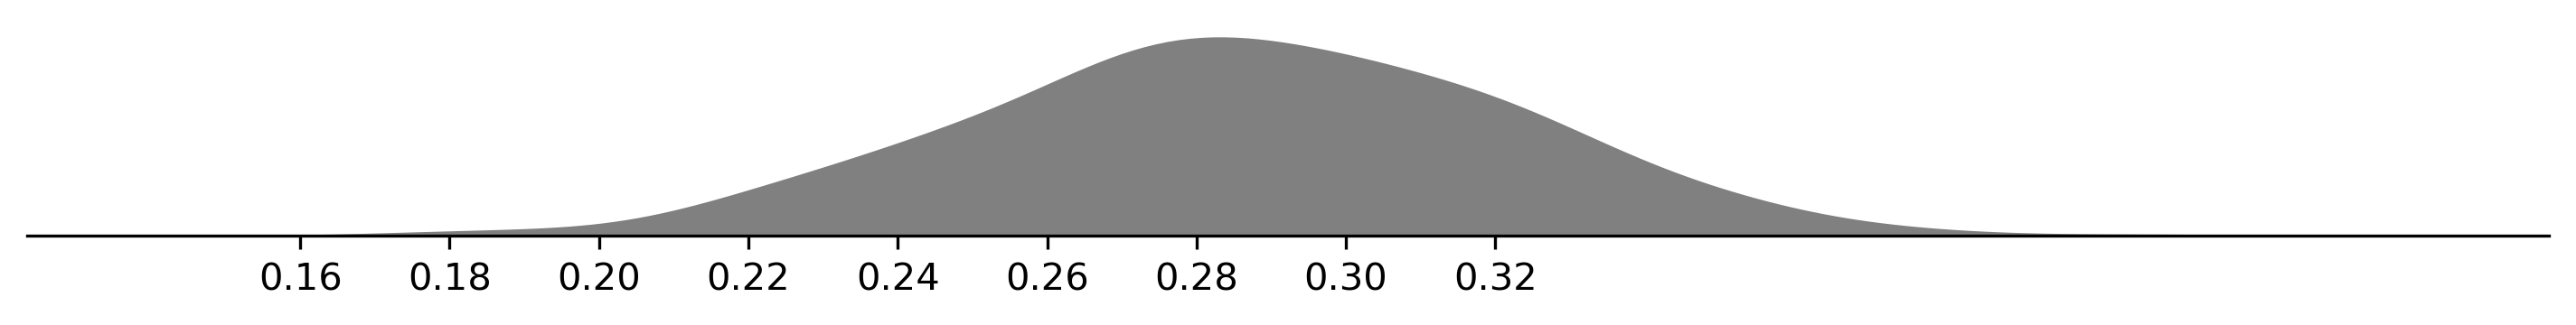

In [47]:
# training data fitness distribution
font = {'size' : 10}
matplotlib.rc('font', **font)
plt.figure(figsize=(12, 1), dpi=300)
sns.kdeplot(
    ycal_n, fill=True, linewidth=0, alpha=1, color='gray', bw_adjust=1.2
);
sns.despine(left=True)
plt.yticks([])
plt.ylabel(None)
plt.xticks(np.arange(0.16, 0.33, 0.02));

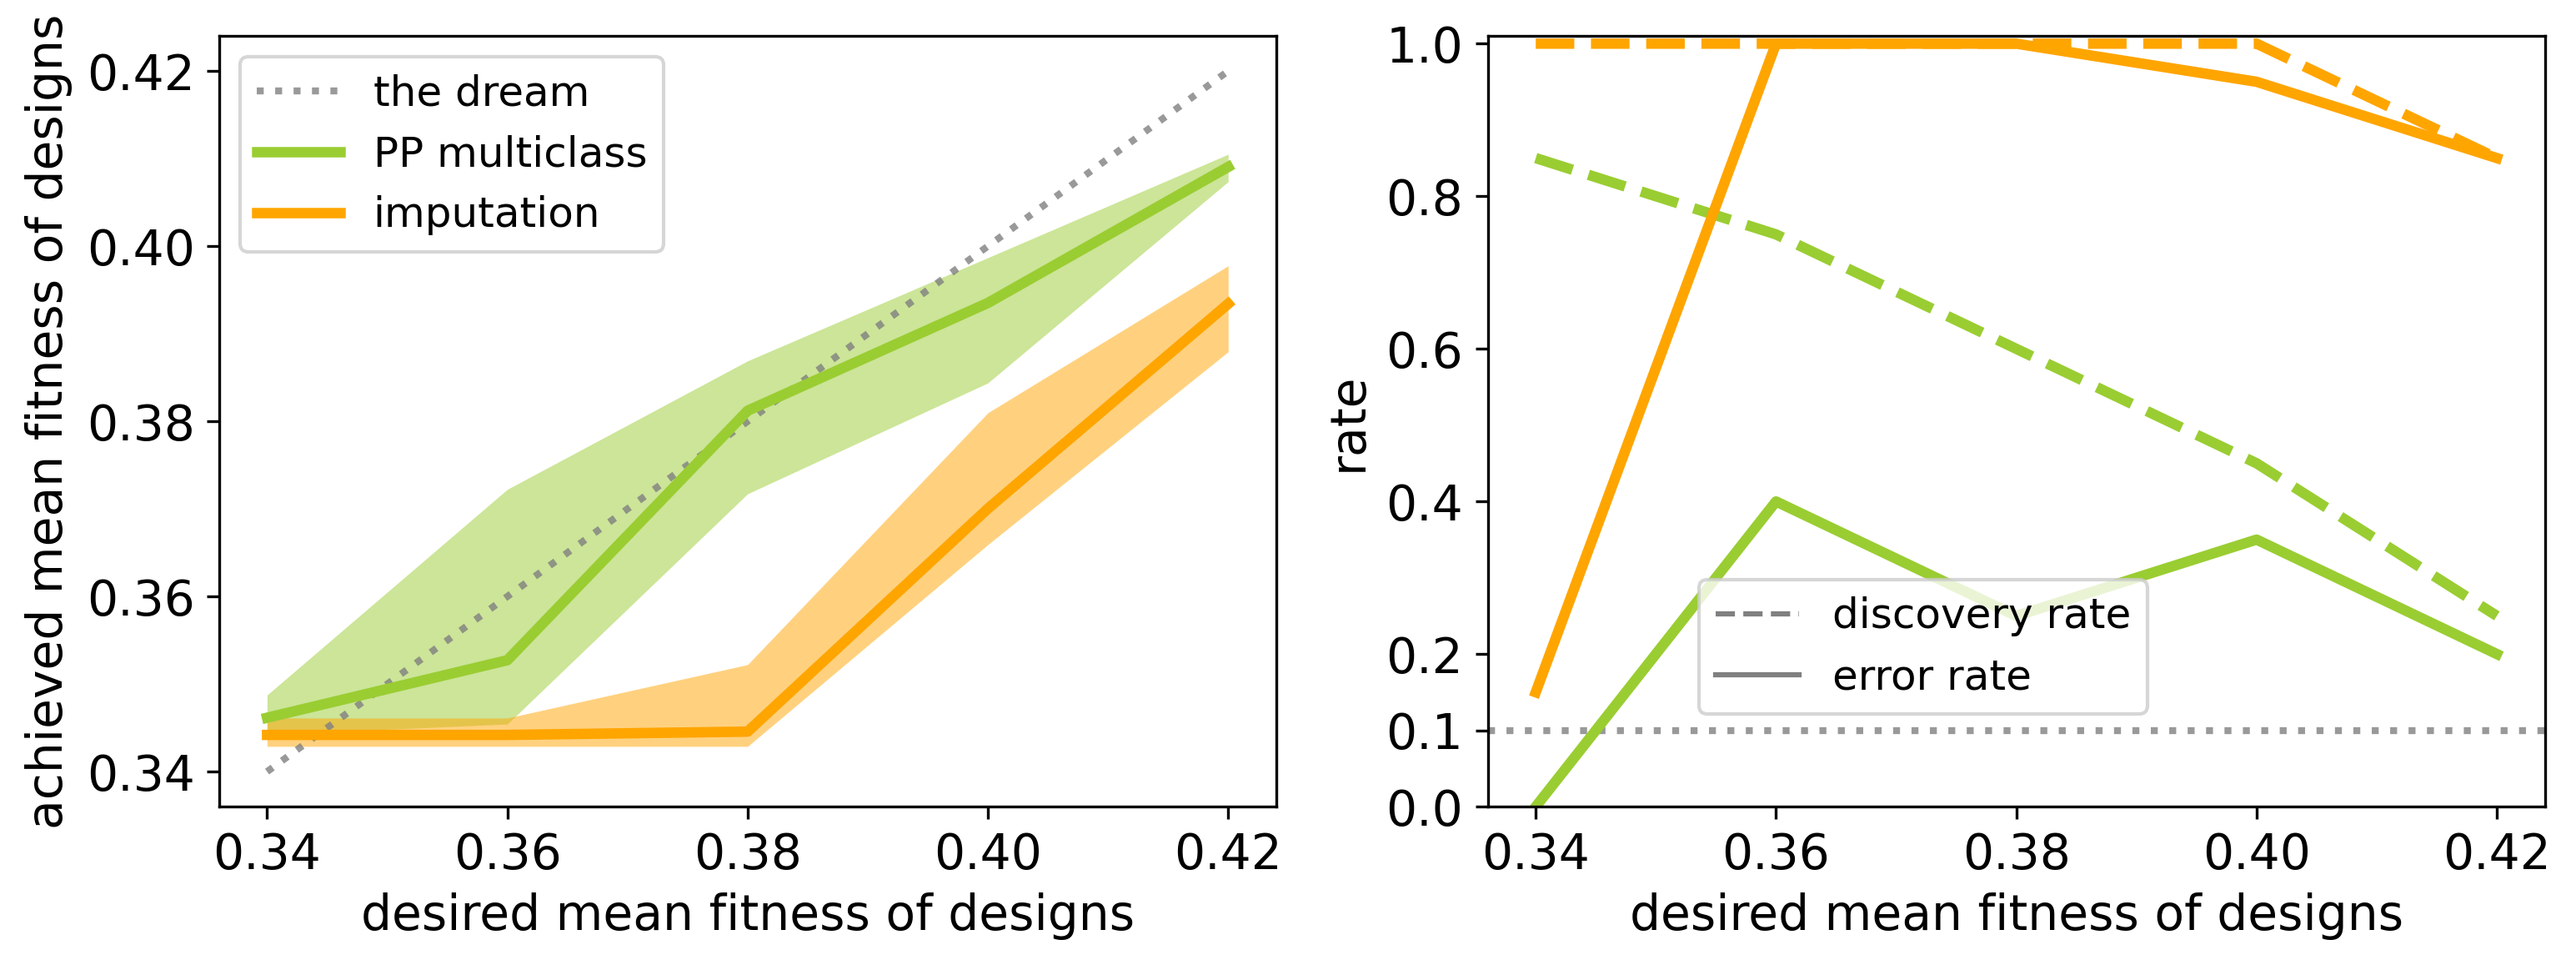

In [14]:
font = {'size' : 14}
matplotlib.rc('font', **font)
i0 = 0
ilast = len(taus) - 1
idx = np.arange(i0, ilast)

# plt.figure(figsize=(5.5, 8), dpi=300)
plt.figure(figsize=(12, 4), dpi=300)

plt.subplot(121)
plt.plot(taus[idx], taus[idx], ':', color='gray', linewidth=2, alpha=0.8, label='the dream')
plt.fill_between(taus[idx], ppq_txq[idx, 0], ppq_txq[idx, 2], alpha=0.5, linewidth=0, color='yellowgreen');
plt.plot(taus[idx], ppq_txq[idx, 1], linewidth=3, color='yellowgreen', label='PP multiclass');
plt.fill_between(taus[idx], impq_txq[idx, 0], impq_txq[idx, 2], alpha=0.5, linewidth=0, color='orange');
plt.plot(taus[idx], impq_txq[idx, 1], linewidth=3, color='orange', label='imputation');
plt.legend(fontsize=12)
plt.xlabel('desired mean fitness of designs');
plt.ylabel('achieved mean fitness of designs');

plt.subplot(122)
plt.axhline(alpha, linestyle=':', color='gray', linewidth=2, alpha=0.8)
plt.plot(taus[idx], ppfwer_t[idx], linewidth=3, color='yellowgreen');
plt.plot(taus[idx], ppdisc_t[idx], linestyle='--', linewidth=3, color='yellowgreen');
plt.plot(taus[idx], impfwer_t[idx], linewidth=3, color='orange');
plt.plot(taus[idx], impdisc_t[idx], linestyle='--', linewidth=3, color='orange');
plt.plot([0.4, 0.4], [2, 2], linestyle='--', color='gray', label='discovery rate');
plt.plot([0.4, 0.4], [2, 2], linestyle='-', color='gray', label='error rate');
plt.legend(fontsize=12, loc=(0.2, 0.12));
plt.xlabel('desired mean fitness of designs');
plt.ylabel('rate');
plt.ylim([0, 1.01])
plt.yticks([0, 0.1, 0.2, 0.4, 0.6, 0.8, 1]);